In [1]:
%load_ext autoreload
%autoreload 2

# IMPORTS

In [2]:
# data
import numpy as np
import pandas as pd

# graphics
import plotly.express as px
import matplotlib.pyplot as plt

# stats
import statsmodels.api as sm

#tracking
import mlflow
import mlflow.statsmodels


# other
import itertools
from tqdm.notebook import tqdm

# src
from src.utilities import from_pickle, to_pickle

# PATHS & NAMES

In [3]:
MODELS_FOLDER = "../models"
REPORT_FOLDER = "../reports"
INTERIM_FOLDER = "../data/interim"

GRID_SARIMAX = "grid_sarimax.pkl"
DEVSET_FILENAME = "devset.pkl"
TESTSET_FILENAME = "testset.pkl"

GRID_SARIMAX_FILEPATH = f"{INTERIM_FOLDER}/{GRID_SARIMAX}"
DEVSET_FILEPATH = f"{INTERIM_FOLDER}/{DEVSET_FILENAME}"
TESTSET_FILEPATH = f"{INTERIM_FOLDER}/{TESTSET_FILENAME}"

TARGET = "y"
LAG_TARGET = "x_y_lagged"

FIG_WIDTH = 15
FIG_HEIGHT = 3

DO_SARIMA_GRID_SEARCH = False

mlflow.set_tracking_uri(f"{MODELS_FOLDER}/mlruns")

# DATA

In [4]:
devset = from_pickle(DEVSET_FILEPATH)
testset = from_pickle(TESTSET_FILEPATH)

## train-validate split

In [5]:
y = devset[TARGET]

pred_cutoff = int(y.shape[0]*0.8)
pred_cutoff_date = y.index[pred_cutoff]

# as time series is long, show only half of it
obs_cutoff = int(y.shape[0]*0.5)
obs_cutoff_date = y.index[obs_cutoff]

# MODELS

## SARIMA

## parameters grid search

In [6]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(param[0], param[1], param[2], 24) for param in pdq]

In [7]:
sarimax_results = {"params":[],"params_seasonal":[],"mse":[],"aic":[]}

# GRID SEARCH: takes 6 mins
if DO_SARIMA_GRID_SEARCH:
    for param in tqdm(pdq):
        for param_seasonal in tqdm(seasonal_pdq):
            model = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            sarimax_results["params"].append(param)
            sarimax_results["params_seasonal"].append(param_seasonal)
            sarimax_results["mse"].append(results.mse)
            sarimax_results["aic"].append(results.aic)

    grid_sarimax = pd.DataFrame(sarimax_results)
    to_pickle(grid_sarimax, GRID_SARIMAX_FILEPATH)

else:
    grid_sarimax = from_pickle(GRID_SARIMAX_FILEPATH)

In [8]:
optimal_pdq = grid_sarimax.sort_values(by=["aic", "mse"], ascending=True).iloc[0]["params"]
optimal_season_pdq = grid_sarimax.sort_values(by=["aic", "mse"], ascending=True).iloc[0]["params_seasonal"]

## best model

In [9]:
# reduce size of the data to keep models small
reduced_size = 150
total_size = 200
y_reduced = y[:total_size]
pred_reduced_cutoff_date = y.index[reduced_size]

c:\_root\_personal\_repos\financial-timeseries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\_root\_personal\_repos\financial-timeseries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\_root\_personal\_repos\financial-timeseries\.venv\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


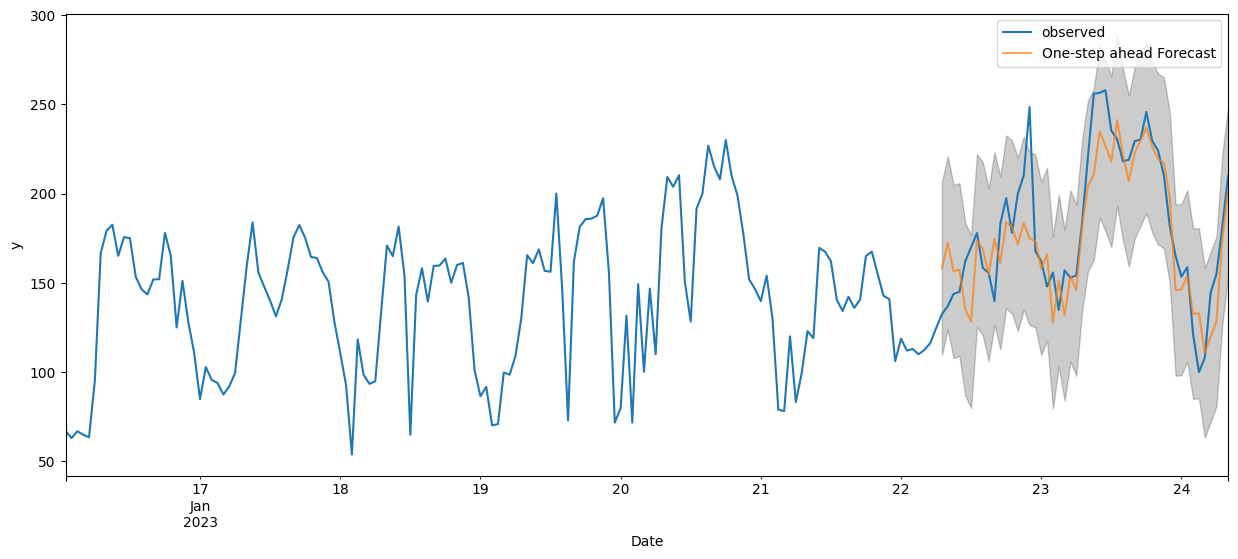

In [10]:
with mlflow.start_run():

    mlflow.log_param("order", optimal_pdq)
    mlflow.log_param("seasonal_order", optimal_season_pdq)

    model = sm.tsa.statespace.SARIMAX(y_reduced,
                                    order=optimal_pdq,
                                    seasonal_order=optimal_season_pdq,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = model.fit()

    mlflow.statsmodels.log_model(results, "sarimax_model")

    mlflow.log_metric("aic", results.aic)
    mlflow.log_metric("mse", results.mse)

    # daignostics plot
    fig = results.plot_diagnostics(figsize=(FIG_WIDTH, FIG_HEIGHT*2))
    plt.tight_layout()
    diagnostics_plot_path = "diagnostics_plot.png"
    plt.savefig(diagnostics_plot_path)
    mlflow.log_artifact(diagnostics_plot_path)
    plt.close(fig)

    # predictions plot
    pred = results.get_prediction(start=pd.to_datetime(pred_reduced_cutoff_date), dynamic=False)
    pred_ci = pred.conf_int()

    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT*2))
    ax = y_reduced.plot(label='observed')
    pred.predicted_mean.plot(ax=ax, 
                             label='One-step ahead Forecast', 
                             alpha=.7)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('y')
    plt.legend()
    predictions_plot_path = "predictions_plot.png"
    plt.savefig(predictions_plot_path)
    mlflow.log_artifact(predictions_plot_path)

In [11]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9116      0.052     17.431      0.000       0.809       1.014
ma.L1         -0.4252      0.098     -4.342      0.000      -0.617      -0.233
ar.S.L24      -0.0164      0.023     -0.703      0.482      -0.062       0.029
ma.S.L24      -1.0000      0.107     -9.303      0.000      -1.211      -0.789
sigma2       521.5140      0.000   2.53e+06      0.000     521.514     521.514


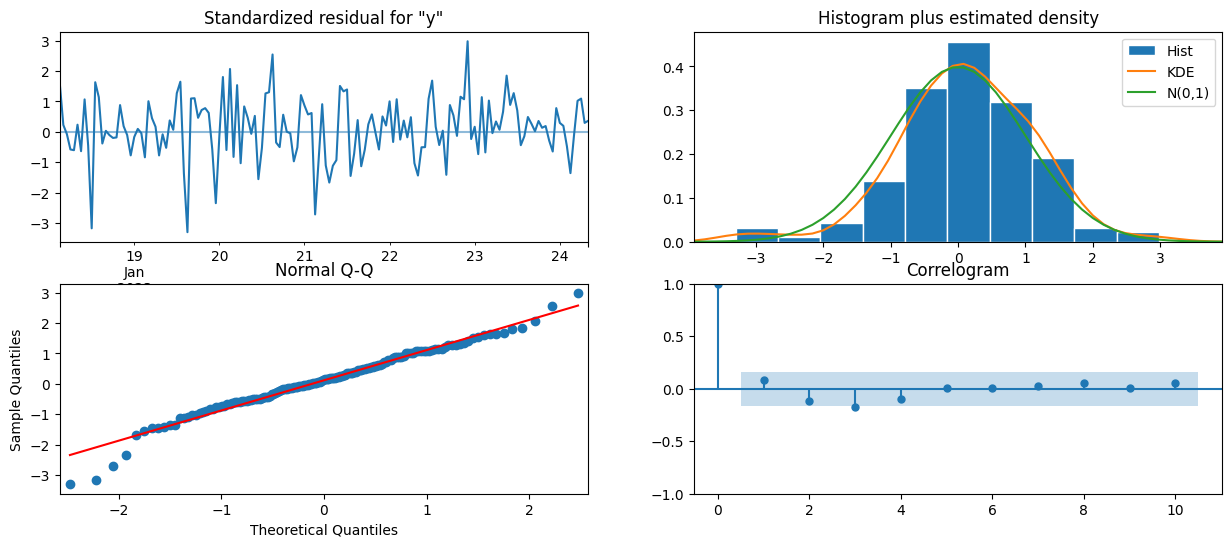

In [12]:
results.plot_diagnostics(figsize=(FIG_WIDTH, FIG_HEIGHT*2))
plt.show()

## FPROPHET

FIXME! cannot install package on Windows machine

## RNN

## LSTM

## GRU

## Encoder-decoder